## UNet training

This notebook demonstrests the setup and training of a UNet segmentation network with an ImageNet backbone architecture.

Training is done using the fastai library. To install first pick correct pytorch library:
https://pytorch.org/get-started/locally/

Then install fastai:
```
 pip install fastai
```
https://docs.fast.ai/install.html

## Experiment


- Big Dataset 15 locations
- Tiling with offset (256,256), noframe, no stride
- Backbone ResNet34
- Imagnet normalization
- Weighted Crossy Entropy with ratio

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Load Dataset

In [16]:
# function to be passed when creating a databunch to find label tile corresponding to an image tile
# since corresponding image and label tiles have the same name this is a simple function
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [17]:
# supply the labels corresponding to binary classes
codes = np.array(['Background', 'Flood'],dtype=str); codes

array(['Background', 'Flood'], dtype='<U10')

In [18]:
gpu_mem_get()

GPUMemory(total=11441, free=11429, used=11)

In [19]:
import torch
torch.cuda.get_device_name(0)

'Tesla K80'

In [20]:
# set the image size to half of the original (not now)
size = src_size

free = gpu_mem_get_free_no_cache()

if free > 8200: bs=32 #Trying higher batch size
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=32, have 11429MB of GPU RAM free


In [21]:
#If you want to run an existing experiment, load the idx and SKIP the next two, otherwise skip this
train_idx=np.loadtxt('train_idx.csv',delimiter=",").astype(int)
valid_idx=np.loadtxt('valid_idx.csv',delimiter=",").astype(int)


src = (SegmentationItemList.from_folder(path_img)) 

### define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

src = (src.split_by_idxs(train_idx=train_idx, valid_idx=valid_idx) #split by index
           .label_from_func(get_y_fn, classes=codes))

data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
#Shuffle the index and then split in train, val, test
src = (SegmentationItemList.from_folder(path_img))
n=len(src) #number of images in the dataset
print("Number of images in the dataset:",n)
arr = np.arange(n) #array 0...n-1
np.random.shuffle(arr) # shuffle it 

train_idx=arr[0:np.int(np.round(0.80*n))] #80% train
valid_idx=arr[np.int(np.round(0.80*n)):np.int(np.round(0.90*n))] #10% validation
test_idx=arr[np.int(np.round(0.90*n)):] #10% test

### define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

src = (src.split_by_idxs(train_idx=train_idx, valid_idx=valid_idx) #split by index
           .label_from_func(get_y_fn, classes=codes))

data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

np.savetxt("big_train_undersample_idx.csv", train_idx, delimiter=",")
np.savetxt("big_valid_undersample_idx.csv", valid_idx, delimiter=",")
np.savetxt("big_test_undersample_idx.csv", test_idx, delimiter=",")

In [22]:
#The test set is in the data_test.valid_dl. it is 256x256
data_test = (SegmentationItemList.from_folder(path_img)
             .split_by_idxs(train_idx=test_idx, valid_idx=test_idx) 
             .label_from_func(get_y_fn, classes=codes)
             .transform(tfms, size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats)
       ) 

## Investigation of the Dataset

In [23]:
print("Dataset:")
data

Dataset:


ImageDataBunch;

Train: LabelList (46502 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Valid: LabelList (5813 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Test: None

In [24]:
data.c

2

In [25]:
print("Test set") #Dataset will be in data_test.valid_dl
data_test.valid_ds

Test set


LabelList (5813 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample

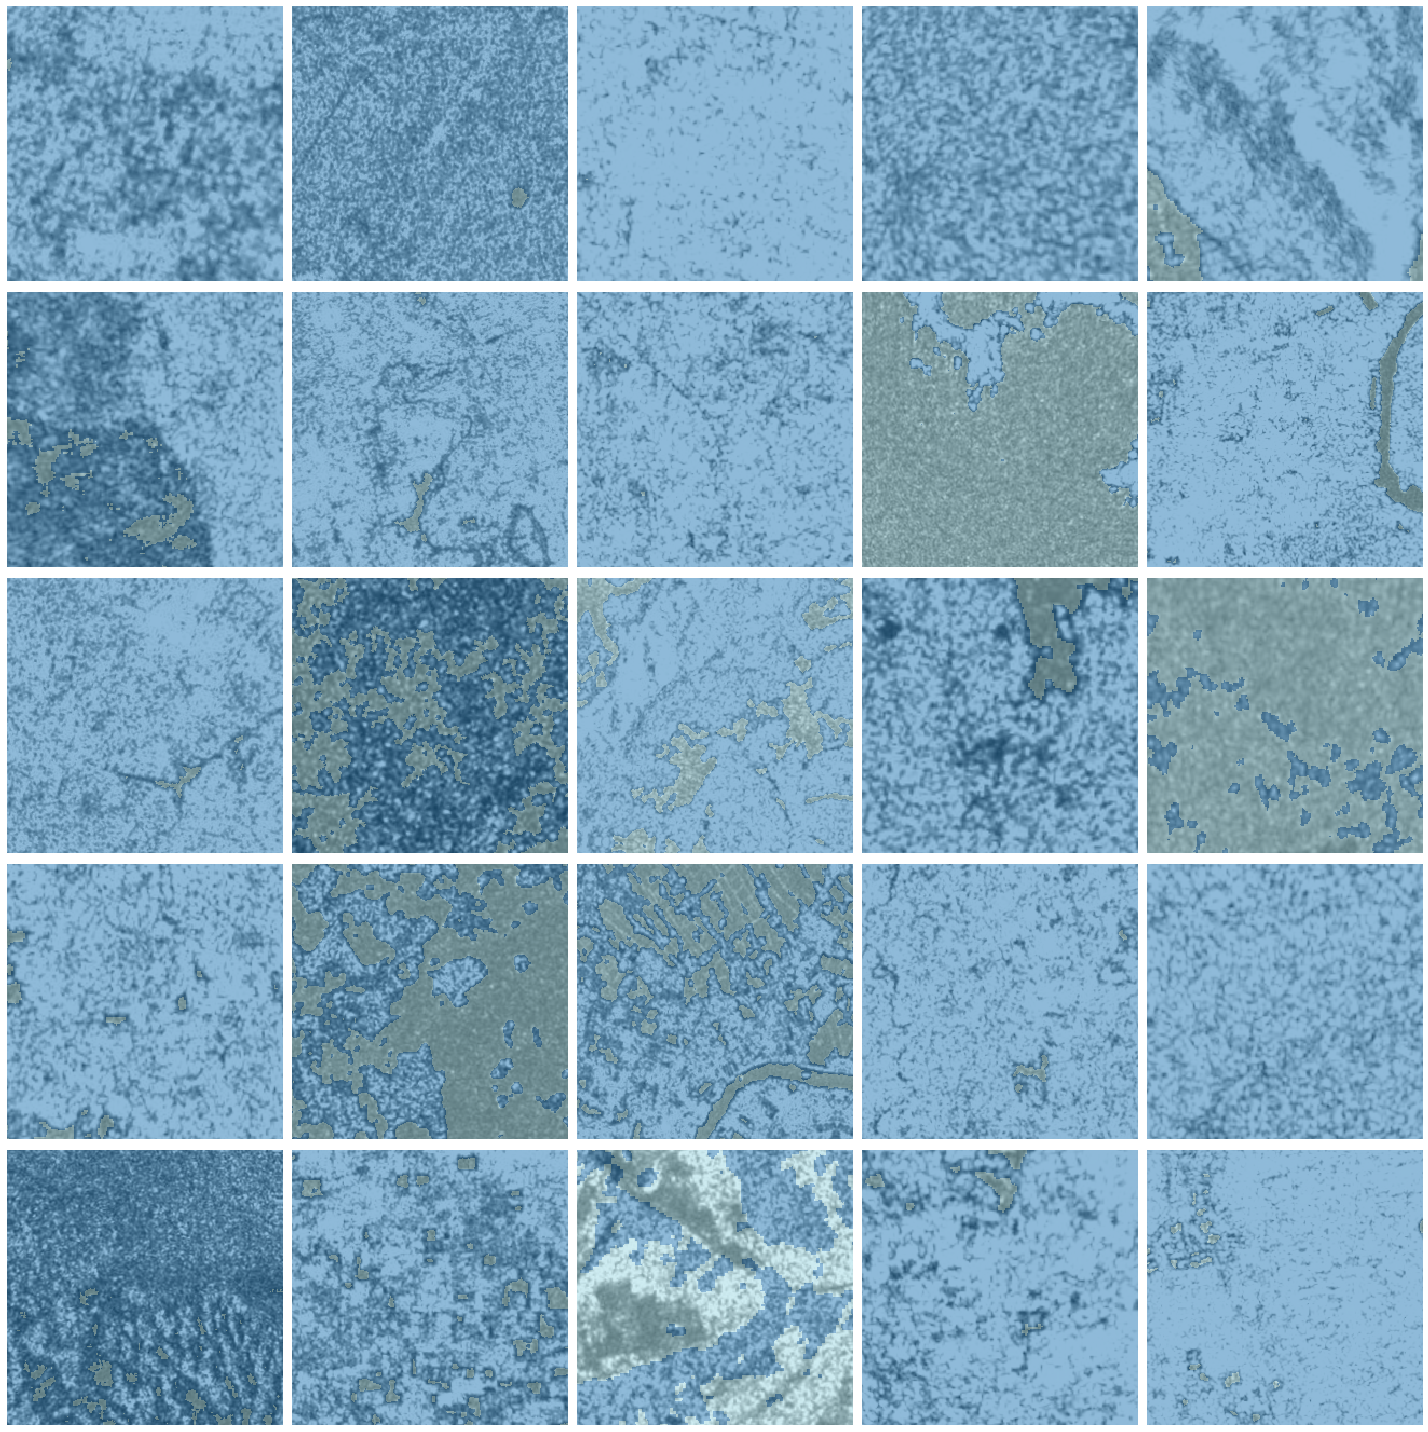

In [26]:
# show batch of data
data.show_batch(ds_type=DatasetType.Train)

# Model

In [27]:
name2id = {v:k for k,v in enumerate(codes)}; name2id

{'Background': 0, 'Flood': 1}

In [28]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

def acc_camvid(input, target):
    'define pixel-level accuracy'
    target = target.squeeze(1)
    mask = target
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def acc_background(input, target):
    'define pixel-level accuracy just for background'
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def acc_flood(input, target):
    'define pixel-level accuracy just for flood'
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

acc_05= partial(accuracy_thresh, thresh=0.5)
f_score=partial(fbeta, thresh=0.2)#partial call fbeta with a thresh 0.2

In [29]:
# we output overall accuracy, flood and background accuracy
metrics = [acc_camvid, acc_flood ,dice]

In [30]:
# set weight-decay
wd = 1e-2

Implement a weighted loss function to compensate for imbalance in pixel classes

In [31]:
#weights give the class imbalance
weights = np.ones(2)
weights[0] = 0.163 #weights for the unflooded class is the ratio of the flooded pixels
weights[1] = 0.837 #and vice-versa
class_weights = torch.FloatTensor(weights).cuda() #weights/ rescaling factor not ratio!

In [32]:
# here using resnet-? backbone architecture 
# fp16 Uses the MixedPrecision callback to train in mixed precision (i.e. forward and backward passes using fp16, with weight updates using fp32), using all NVIDIA recommendations for ensuring speed and accuracy.
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [34]:
#Suggested by https://github.com/fastai/fastai/issues/1768
learn.loss_func=CrossEntropyFlat(axis=1, weight = class_weights.cuda())

In [37]:
learn.loss_funcunc_func.weight

tensor([0.1630, 0.8370], device='cuda:0')

### Stage 0

Tune learning rate using fastai's learning rate finder. This is done by choose the point of maximum slope before the minimum

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


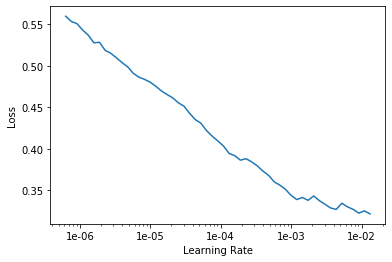

In [38]:
lr_find(learn)
learn.recorder.plot()

In [40]:
lr = 5e-4

In [42]:
from fastai.callbacks import *
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice',
                                         mode='max',
                                         name='flood-focaldice-stage0-best')
                    ]
                   )

Better model found at epoch 0 with dice value: 0.6505447030067444.
Better model found at epoch 2 with dice value: 0.6524041295051575.
Better model found at epoch 5 with dice value: 0.668891429901123.
Better model found at epoch 7 with dice value: 0.6802083849906921.
Better model found at epoch 8 with dice value: 0.6810515522956848.
Better model found at epoch 9 with dice value: 0.6846606135368347.


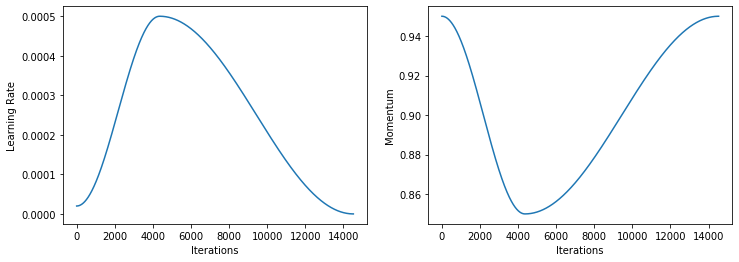

In [43]:
learn.recorder.plot_lr(show_moms=True)

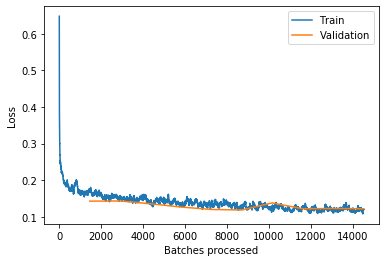

In [44]:
learn.recorder.plot_losses()

In [47]:
learn.save('stage-0-0-exp6-bis')

In [48]:
learn.load('stage-0-0-exp6-bis');

In [49]:
learn.export()
learn.purge()

Learner(data=ImageDataBunch;

Train: LabelList (46502 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Valid: LabelList (5813 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 

#### Testing on one tile from the test set

In [50]:
idx=1235

In [51]:
data_test.valid_ds[idx]

(Image (3, 256, 256), ImageSegment (1, 256, 256))

In [52]:
data_test.valid_ds[idx][0].data

tensor([[[0.9843, 1.0000, 1.0000,  ..., 1.0000, 0.9451, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 0.9647, 0.9451, 1.0000],
         [0.9647, 1.0000, 0.9608,  ..., 0.7843, 0.8588, 0.9059],
         ...,
         [0.8196, 0.6824, 0.7333,  ..., 1.0000, 1.0000, 0.9843],
         [0.9020, 0.8980, 0.8196,  ..., 0.9922, 0.9765, 0.9843],
         [0.9255, 1.0000, 0.9686,  ..., 0.9059, 0.9725, 1.0000]],

        [[0.9843, 1.0000, 1.0000,  ..., 1.0000, 0.9451, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 0.9647, 0.9451, 1.0000],
         [0.9647, 1.0000, 0.9608,  ..., 0.7843, 0.8588, 0.9059],
         ...,
         [0.8196, 0.6824, 0.7333,  ..., 1.0000, 1.0000, 0.9843],
         [0.9020, 0.8980, 0.8196,  ..., 0.9922, 0.9765, 0.9843],
         [0.9255, 1.0000, 0.9686,  ..., 0.9059, 0.9725, 1.0000]],

        [[0.9843, 1.0000, 1.0000,  ..., 1.0000, 0.9451, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 0.9647, 0.9451, 1.0000],
         [0.9647, 1.0000, 0.9608,  ..., 0.7843, 0.8588, 0.

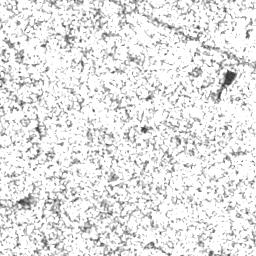

In [53]:
img = data_test.valid_ds[idx][0]
img

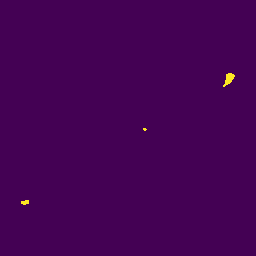

In [54]:
gt = data_test.valid_ds[idx][1]
gt

In [55]:
print('Max', gt.data[0,:,:].max())
print('Min', gt.data[0,:,:].min())

Max tensor(1)
Min tensor(0)


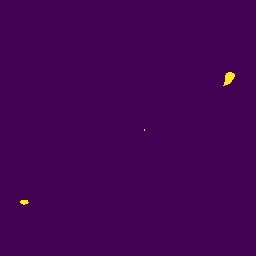

In [56]:
pred=learn.predict(img)[0]
pred

In [57]:
print('Max', pred.data[0,:,:].max())
print('Min', pred.data[0,:,:].min())

Max tensor(1)
Min tensor(0)


In [58]:
np.unique(pred.data[0,:,:])

array([0, 1])

In [59]:
np_pred=np.array(pred.data[0]).reshape(-1)
np_gt=np.array(gt.data[0]).reshape(-1)
print('Accuracy:',100*accuracy_score(np_gt,np_pred))
print('Precision:',100*precision_score(np_gt,np_pred))
print('Recall:',100*recall_score(np_gt,np_pred))

Accuracy: 99.945068359375
Precision: 83.7037037037037
Recall: 88.9763779527559


We now unfreeze the model to train all nodes

In [78]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 3.31E-07


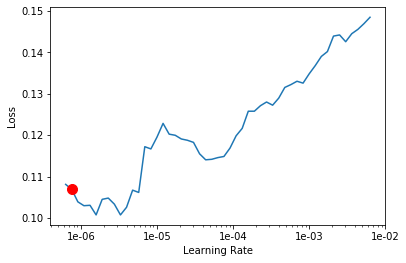

In [82]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [84]:
learn.fit_one_cycle(20, max_lr=slice(3e-6,3e-5), 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice',
                                           mode='max',
                                           name='stage-0-1-exp6-bis-best')
                    ]
                   )

Better model found at epoch 0 with dice value: 0.6885996460914612.
Better model found at epoch 2 with dice value: 0.6898170113563538.
Better model found at epoch 7 with dice value: 0.6916761994361877.
Better model found at epoch 9 with dice value: 0.6920285820960999.
Better model found at epoch 11 with dice value: 0.7002575397491455.
Better model found at epoch 16 with dice value: 0.7008234262466431.
Better model found at epoch 17 with dice value: 0.7010890245437622.


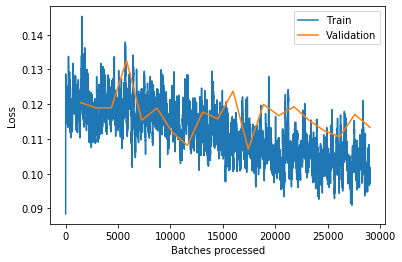

In [85]:
learn.recorder.plot_losses()

In [86]:
learn.save('stage-0-1-exp6-bis')

In [87]:
learn.load('stage-0-1-exp6-bis')

Learner(data=ImageDataBunch;

Train: LabelList (46502 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Valid: LabelList (5813 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 

In [88]:
learn.export()
learn.purge()

Learner(data=ImageDataBunch;

Train: LabelList (46502 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Valid: LabelList (5813 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /root/efs/users/edoardo/flood_mapping/flood_dataset/segmentation_data/tiles_big_dataset_img_undersample;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 

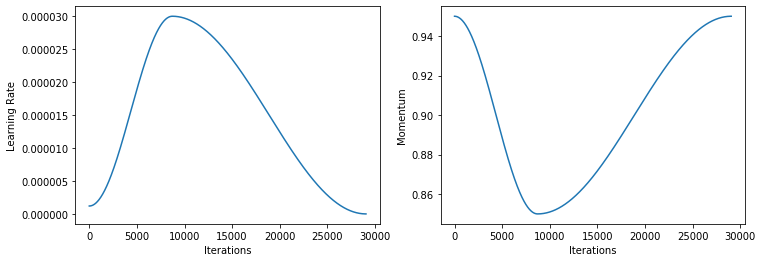

In [89]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.recorder.plot_lr()

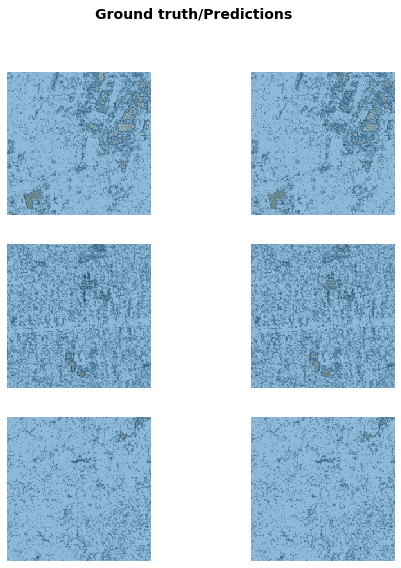

In [90]:
learn.show_results(rows = 3, figsize=(8,9))

### Test on one image of the test set

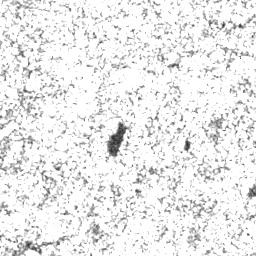

In [91]:
idx=365
img = data_test.valid_ds[idx][0]
img

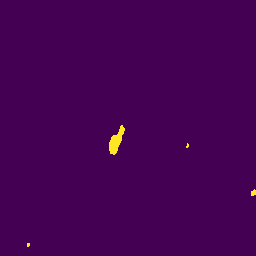

In [92]:
gt = data_test.valid_ds[idx][1]
gt

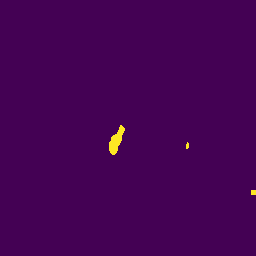

In [93]:
pred=learn.predict(img)[0]
pred

In [94]:
np_pred=np.array(pred.data[0]).reshape(-1)
np_gt=np.array(gt.data[0]).reshape(-1)
print('Accuracy:',accuracy_score(np_gt,np_pred))
print('Precision:',precision_score(np_gt,np_pred))
print('Recall:',recall_score(np_gt,np_pred))

Accuracy: 0.9994049072265625
Precision: 0.9328621908127208
Recall: 0.9295774647887324
